NEW SOLOUTION ALLOWS FOR SHUFFLING OF BOTH LOADERS


In [12]:
import numpy as np
import os

# Directory where the bundles will be saved
data_dir = 'data'

# Ensure the data directory exists
os.makedirs(data_dir, exist_ok=True)

# Generate the original data and save to disk
num_of_bundles = 4
bundle_size = 4

for i in range(num_of_bundles):
    start_value = i * bundle_size + 1
    end_value = start_value + bundle_size
    data = np.arange(start_value, end_value).reshape(bundle_size, 1, 1)
    file_path = os.path.join(data_dir, f'bundle_{i}.npy')
    np.save(file_path, data)


# load and print the data
for i in range(num_of_bundles):
    file_path = os.path.join(data_dir, f'bundle_{i}.npy')
    data = np.load(file_path)
    print(f'Bundle {i}: {data}')

    


Bundle 0: [[[1]]

 [[2]]

 [[3]]

 [[4]]]
Bundle 1: [[[5]]

 [[6]]

 [[7]]

 [[8]]]
Bundle 2: [[[ 9]]

 [[10]]

 [[11]]

 [[12]]]
Bundle 3: [[[13]]

 [[14]]

 [[15]]

 [[16]]]


In [31]:

import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
import torch
import os

# Dummy dataset class
class DTM_Dataset(Dataset):
    """
    Disk to Memory Dataset
    Loads data from disk to memory in the form of bundles to reduce i/o operations

    Args:
    data_dir: str, the directory where the data files are stored

    Methods:
    __len__: returns the number of data files

    __getitem__: returns a data file
    
    """
    def __init__(self, data_dir):
        # Get all .npy files in the specified directory
        self.data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')]
        self.size = len(self.data_files)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        data = np.load(self.data_files[idx])
        return torch.tensor(data, dtype=torch.float32)   # allow precision controll, not sure if better to do in here or directly inside MTN dataset?
    
    

class MTN_Dataset(Dataset):
    """
    Memory to Network Dataset
    Loads data from memory to the neural network in the form of individual samples, handling shuffling across the two datasets and iteration bewteen them

    Args:
    large_data_bundles_size: int, the number of individual files in each bundle
    large_batch_size: int, the number of bundles to load into memory at once
    shuffle_data: bool, whether to shuffle the data across both large and small batches

    Methods:
    __len__: returns the number of individual samples in the entire dataset of bundles

    __getitem__: returns a single sample from memory
    """

    def __init__(self, dataset_path_ondisk, large_data_bundles_size=4, large_batch_size=1, shuffle_data=False):
        self.large_dataset = DTM_Dataset(dataset_path_ondisk)
        self.large_dataloader = DataLoader(self.large_dataset, large_batch_size, shuffle_data)
        self.large_data_bundles_size = large_data_bundles_size
        self.large_batch_size = large_batch_size
        self.indices = list(range(self.large_data_bundles_size * self.large_batch_size))
        self.shuffle_data = shuffle_data

    def restart_large_dataloader(self):
        self.large_dataloader_iterator = iter(self.large_dataloader)

    def __len__(self):
        return len(self.large_dataset) * self.large_data_bundles_size
    
    def __getitem__(self, idx):
        if idx == 0:
            self.restart_large_dataloader()

        if idx % (self.large_data_bundles_size * self.large_batch_size) == 0:
            # Load a new bundle of data
            print('Loading new bundle of data from disk...')
            self.data = next(self.large_dataloader_iterator)
            print(f'New bundle of data loaded: {self.data.squeeze().numpy()}')
            self.shuffled_indices = self.indices.copy()
            if self.shuffle_data:
                random.shuffle(self.shuffled_indices)
                print(f'Indices  : {self.indices} ')
                print(f'Shuffled : {self.shuffled_indices}')

        internal_bundle_idx = self.shuffled_indices[idx % (self.large_data_bundles_size * self.large_batch_size)]

        return self.data[internal_bundle_idx // self.large_data_bundles_size, internal_bundle_idx % self.large_data_bundles_size]
    



dataset_path_ondisk = 'data'    # Path to the directory where the data files are stored on disk in bundles
large_data_bundles_size = 4     # the number of individual files in each bundle
number_of_bundles_to_memory = 4 # Essentially the 'Large batch Size' i.e how many bundles to load into memory at once [Must be less than or equal to the number of bundles in the dataset on disk]
small_batch_size = 18            # Batch Size for loading into the neural net from the in memory bundles               
shuffle_data = True             # Shuffle the data across both large and small batches

small_dataset = MTN_Dataset(dataset_path_ondisk, large_data_bundles_size, number_of_bundles_to_memory, shuffle_data)
small_dataloader = DataLoader(small_dataset, small_batch_size) # Shuffle is handled by the dataset, set with the variable 'shuffle_data'. It must not be applied here otherwise will induce errors in the logic based on index value

# Iterate over batches
for epoch in range(2):
    print(f'\n\n  Epoch {epoch + 1}')
    for batch_idx, data in enumerate(small_dataloader):
        print(f'Batch {batch_idx}, Data: {data.squeeze().squeeze()}')  # Print the data in each batch






  Epoch 1
Loading new bundle of data from disk...
New bundle of data loaded: [[ 9. 10. 11. 12.]
 [ 5.  6.  7.  8.]
 [13. 14. 15. 16.]
 [ 1.  2.  3.  4.]]
Indices  : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 
Shuffled : [14, 10, 12, 2, 5, 0, 15, 11, 7, 8, 3, 4, 13, 6, 9, 1]
Batch 0, Data: tensor([ 3., 15.,  1., 11.,  6.,  9.,  4., 16.,  8., 13., 12.,  5.,  2.,  7.,
        14., 10.])


  Epoch 2
Loading new bundle of data from disk...
New bundle of data loaded: [[13. 14. 15. 16.]
 [ 5.  6.  7.  8.]
 [ 1.  2.  3.  4.]
 [ 9. 10. 11. 12.]]
Indices  : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 
Shuffled : [9, 10, 2, 6, 13, 5, 7, 15, 3, 1, 12, 4, 8, 14, 11, 0]
Batch 0, Data: tensor([ 2.,  3., 15.,  7., 10.,  6.,  8., 12., 16., 14.,  9.,  5.,  1., 11.,
         4., 13.])


In [36]:
import numpy as np
import os

# Directory where the bundles will be saved
data_dir = 'data'

# Ensure the data directory exists
os.makedirs(data_dir, exist_ok=True)

# Generate the original data and save to disk
num_of_bundles = 4
bundle_size = 4
X = 3
Y = 3

for i in range(num_of_bundles):
    start_value = i * bundle_size * X * Y + 1
    end_value = start_value + bundle_size * X * Y
    data = np.arange(start_value, end_value).reshape(bundle_size, X, Y)
    file_path = os.path.join(data_dir, f'bundle_{i}.npy')
    np.save(file_path, data)


# load and print the data
for i in range(num_of_bundles):
    file_path = os.path.join(data_dir, f'bundle_{i}.npy')
    data = np.load(file_path)
    print(f'Bundle {i}: {data}')

Bundle 0: [[[ 1  2  3]
  [ 4  5  6]
  [ 7  8  9]]

 [[10 11 12]
  [13 14 15]
  [16 17 18]]

 [[19 20 21]
  [22 23 24]
  [25 26 27]]

 [[28 29 30]
  [31 32 33]
  [34 35 36]]]
Bundle 1: [[[37 38 39]
  [40 41 42]
  [43 44 45]]

 [[46 47 48]
  [49 50 51]
  [52 53 54]]

 [[55 56 57]
  [58 59 60]
  [61 62 63]]

 [[64 65 66]
  [67 68 69]
  [70 71 72]]]
Bundle 2: [[[ 73  74  75]
  [ 76  77  78]
  [ 79  80  81]]

 [[ 82  83  84]
  [ 85  86  87]
  [ 88  89  90]]

 [[ 91  92  93]
  [ 94  95  96]
  [ 97  98  99]]

 [[100 101 102]
  [103 104 105]
  [106 107 108]]]
Bundle 3: [[[109 110 111]
  [112 113 114]
  [115 116 117]]

 [[118 119 120]
  [121 122 123]
  [124 125 126]]

 [[127 128 129]
  [130 131 132]
  [133 134 135]]

 [[136 137 138]
  [139 140 141]
  [142 143 144]]]


CLEANUP FOR DEPLOYMENT 

In [37]:

import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
import torch
import os

# Dummy dataset class
class DTM_Dataset(Dataset):
    """
    Disk to Memory Dataset
    Loads data from disk to memory in the form of bundles to reduce i/o operations

    Args:
    data_dir: str, the directory where the data files are stored

    Methods:
    __len__: returns the number of data files

    __getitem__: returns a data file
    
    """
    def __init__(self, data_dir):
        # Get all .npy files in the specified directory
        self.data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')]
        self.size = len(self.data_files)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        data = np.load(self.data_files[idx])
        return data
    
class MTN_Dataset(Dataset):
    """
    Memory to Network Dataset
    Loads data from memory to the neural network in the form of individual samples, handling shuffling across the two datasets and iteration bewteen them

    Args:
    large_data_bundles_size: int, the number of individual files in each bundle
    large_batch_size: int, the number of bundles to load into memory at once
    shuffle_data: bool, whether to shuffle the data across both large and small batches

    Methods:
    __len__: returns the number of individual samples in the entire dataset of bundles

    __getitem__: returns a single sample from memory
    """

    def __init__(self, dataset_path_ondisk, large_data_bundles_size=4, large_batch_size=1, shuffle_data=False, dtype=torch.float32):
        self.large_dataset = DTM_Dataset(dataset_path_ondisk)
        self.large_dataloader = DataLoader(self.large_dataset, large_batch_size, shuffle_data)
        self.large_data_bundles_size = large_data_bundles_size
        self.large_batch_size = large_batch_size
        self.indices = list(range(self.large_data_bundles_size * self.large_batch_size))
        self.shuffle_data = shuffle_data
        self.dtype = dtype

    def __len__(self):
        return len(self.large_dataset) * self.large_data_bundles_size
    
    def __getitem__(self, idx):
        if idx == 0:
            self.large_dataloader_iterator = iter(self.large_dataloader) # Restarts the large/DTM dataloader iterator

        if idx % (self.large_data_bundles_size * self.large_batch_size) == 0: # If the index is a multiple of the bundle size then load a new bundle of data into memory
            # Load a new bundle of data
            self.data = next(self.large_dataloader_iterator)
            self.data = torch.tensor(self.data, dtype = self.dtype) 

            # Shuffling across the bundle, without loosing the ability to use logic based on index
            self.shuffled_indices = self.indices.copy()
            if self.shuffle_data:
                random.shuffle(self.shuffled_indices)

        internal_bundle_idx = self.shuffled_indices[idx % (self.large_data_bundles_size * self.large_batch_size)] # Get the index of the data in the bundle

        return self.data[internal_bundle_idx // self.large_data_bundles_size, internal_bundle_idx % self.large_data_bundles_size] 
    



dataset_path_ondisk = 'data'    # Path to the directory where the data files are stored on disk in bundles
large_data_bundles_size = 4     # the number of individual files in each bundle
number_of_bundles_to_memory = 4 # Essentially the 'Large batch Size' i.e how many bundles to load into memory at once [Must be less than or equal to the number of bundles in the dataset on disk]
small_batch_size = 2            # Batch Size for loading into the neural net from the in memory bundles               
shuffle_data = True             # Shuffle the data across both large and small batches

small_dataset = MTN_Dataset(dataset_path_ondisk, large_data_bundles_size, number_of_bundles_to_memory, shuffle_data)
small_dataloader = DataLoader(small_dataset, small_batch_size) # Shuffle is handled by the dataset, set with the variable 'shuffle_data'. It must not be applied here otherwise will induce errors in the logic based on index value

# Iterate over batches
for epoch in range(2):
    print(f'\n\n  Epoch {epoch + 1}')
    for batch_idx, data in enumerate(small_dataloader):
        print(f'Batch {batch_idx}, Data: {data}')  # Print the data in each batch






  Epoch 1
Batch 0, Data: tensor([[[ 64.,  65.,  66.],
         [ 67.,  68.,  69.],
         [ 70.,  71.,  72.]],

        [[109., 110., 111.],
         [112., 113., 114.],
         [115., 116., 117.]]])
Batch 1, Data: tensor([[[46., 47., 48.],
         [49., 50., 51.],
         [52., 53., 54.]],

        [[19., 20., 21.],
         [22., 23., 24.],
         [25., 26., 27.]]])
Batch 2, Data: tensor([[[37., 38., 39.],
         [40., 41., 42.],
         [43., 44., 45.]],

        [[10., 11., 12.],
         [13., 14., 15.],
         [16., 17., 18.]]])
Batch 3, Data: tensor([[[118., 119., 120.],
         [121., 122., 123.],
         [124., 125., 126.]],

        [[ 55.,  56.,  57.],
         [ 58.,  59.,  60.],
         [ 61.,  62.,  63.]]])
Batch 4, Data: tensor([[[136., 137., 138.],
         [139., 140., 141.],
         [142., 143., 144.]],

        [[ 73.,  74.,  75.],
         [ 76.,  77.,  78.],
         [ 79.,  80.,  81.]]])
Batch 5, Data: tensor([[[91., 92., 93.],
         [94., 95.

C:\Users\Ada\AppData\Local\Temp\ipykernel_75384\511756333.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data, dtype = self.dtype)


In [42]:

import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
import torch
import os

# Dummy dataset class
class DTM_Dataset(Dataset):
    """
    Disk to Memory Dataset
    Loads data from disk to memory in the form of bundles to reduce i/o operations

    Args:
    data_dir: str, the directory where the data files are stored

    Methods:
    __len__: returns the number of data files

    __getitem__: returns a data file
    
    """
    def __init__(self, data_dir):
        # Get all .npy files in the specified directory
        self.data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.pt')]
        self.size = len(self.data_files)

    def __len__(self):
        print(f'Length: {self.size}')
        return self.size

    def __getitem__(self, idx):
        data = torch.load(self.data_files[idx])
        return data
    
class MTN_Dataset(Dataset):
    """
    Memory to Network Dataset
    Loads data from memory to the neural network in the form of individual samples, handling shuffling across the two datasets and iteration bewteen them

    Args:
    large_data_bundles_size: int, the number of individual files in each bundle
    large_batch_size: int, the number of bundles to load into memory at once
    shuffle_data: bool, whether to shuffle the data across both large and small batches

    Methods:
    __len__: returns the number of individual samples in the entire dataset of bundles

    __getitem__: returns a single sample from memory
    """

    def __init__(self, dataset_path_ondisk, large_data_bundles_size=4, large_batch_size=1, shuffle_data=False, dtype=torch.float32):
        self.large_dataset = DTM_Dataset(dataset_path_ondisk)
        self.large_dataloader = DataLoader(self.large_dataset, large_batch_size, shuffle_data)
        self.large_data_bundles_size = large_data_bundles_size
        self.large_batch_size = large_batch_size
        self.indices = list(range(self.large_data_bundles_size * self.large_batch_size))
        self.shuffle_data = shuffle_data
        self.dtype = dtype

    def __len__(self):
        return len(self.large_dataset) * self.large_data_bundles_size
    
    def __getitem__(self, idx):
        if idx == 0:
            self.large_dataloader_iterator = iter(self.large_dataloader) # Restarts the large/DTM dataloader iterator

        if idx % (self.large_data_bundles_size * self.large_batch_size) == 0: # If the index is a multiple of the bundle size then load a new bundle of data into memory
            # Load a new bundle of data
            self.data = next(self.large_dataloader_iterator)
            #self.data = torch.tensor(self.data, dtype = self.dtype) 

            # Shuffling across the bundle, without loosing the ability to use logic based on index
            self.shuffled_indices = self.indices.copy()
            if self.shuffle_data:
                random.shuffle(self.shuffled_indices)

        internal_bundle_idx = self.shuffled_indices[idx % (self.large_data_bundles_size * self.large_batch_size)] # Get the index of the data in the bundle

        return self.data[internal_bundle_idx // self.large_data_bundles_size, internal_bundle_idx % self.large_data_bundles_size] 
    



dataset_path_ondisk = r'N:\Yr 3 Project Datasets\[V2]RDT 50KM Fix\Data\\'    # Path to the directory where the data files are stored on disk in bundles
large_data_bundles_size = 1000     # the number of individual files in each bundle
number_of_bundles_to_memory = 1 # Essentially the 'Large batch Size' i.e how many bundles to load into memory at once [Must be less than or equal to the number of bundles in the dataset on disk]
small_batch_size = 2            # Batch Size for loading into the neural net from the in memory bundles               
shuffle_data = False             # Shuffle the data across both large and small batches

small_dataset = MTN_Dataset(dataset_path_ondisk, large_data_bundles_size, number_of_bundles_to_memory, shuffle_data)
small_dataloader = DataLoader(small_dataset, small_batch_size) # Shuffle is handled by the dataset, set with the variable 'shuffle_data'. It must not be applied here otherwise will induce errors in the logic based on index value





Time without check: 0.684826 seconds
Time with check: 0.371046 seconds
Both lists match


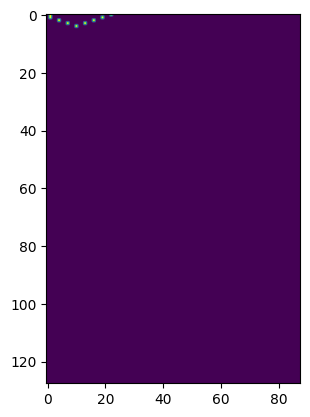

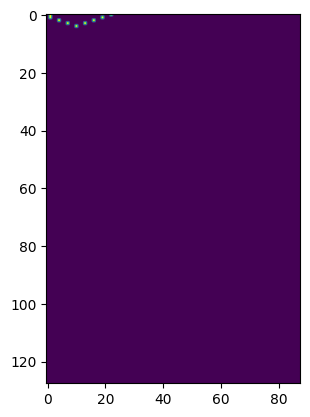

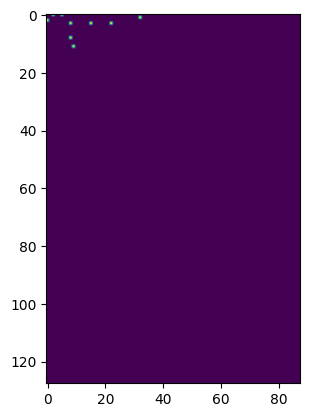

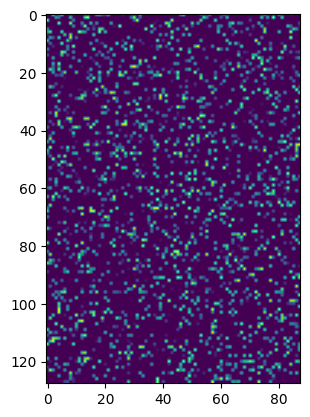

Batch 0


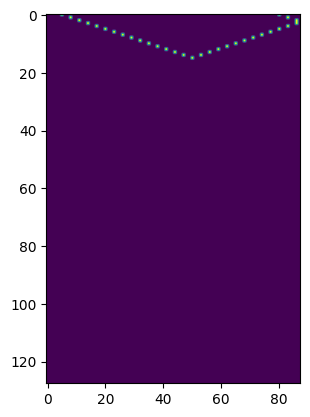

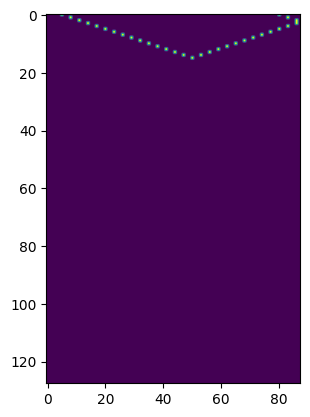

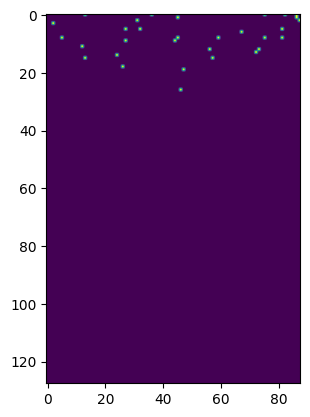

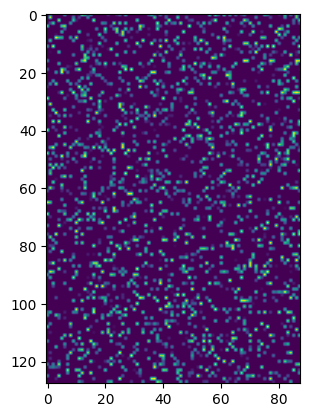

Batch 1


In [86]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
import torch
import os
from tqdm import tqdm
from DC3D_V3.Helper_files.Data_Degradation_Functions import *
from DC3D_V3.Helper_files.Helper_Functions import input_range_to_random_value

# Dummy dataset class
class DTM_Dataset(Dataset):
    """
    Disk to Memory Dataset
    Loads data from disk to memory in the form of bundles to reduce i/o operations

    Args:
    data_dir: str, the directory where the data files are stored

    Methods:
    __len__: returns the number of data files

    __getitem__: returns a data file
    
    """
    def __init__(self, data_dir):
        # Get all .npy files in the specified directory
        self.data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.pt')]
        self.size = len(self.data_files)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        data = torch.load(self.data_files[idx])
        return data
    
class MTN_Dataset(Dataset):
    """
    Memory to Network Dataset
    Loads data from memory to the neural network in the form of individual samples, handling shuffling across the two datasets and iteration bewteen them

    Args:
    large_data_bundles_size: int, the number of individual files in each bundle
    large_batch_size: int, the number of bundles to load into memory at once
    shuffle_data: bool, whether to shuffle the data across both large and small batches

    Methods:
    __len__: returns the number of individual samples in the entire dataset of bundles

    __getitem__: returns a single sample from memory
    """

    def __init__(self, dataset_path_ondisk, large_data_bundles_size=4, large_batch_size=1, shuffle_data=False, dtype=torch.float32):
        self.large_dataset = DTM_Dataset(dataset_path_ondisk)
        self.large_dataloader = DataLoader(self.large_dataset, large_batch_size, shuffle_data)
        self.large_data_bundles_size = large_data_bundles_size
        self.large_batch_size = large_batch_size
        self.indices = list(range(self.large_data_bundles_size * self.large_batch_size))
        self.shuffle_data = shuffle_data
        self.dtype = dtype

    def __len__(self):
        return len(self.large_dataset) * self.large_data_bundles_size
    
    def __getitem__(self, idx):
        if idx == 0:
            self.large_dataloader_iterator = iter(self.large_dataloader) # Restarts the large/DTM dataloader iterator

        if idx % (self.large_data_bundles_size * self.large_batch_size) == 0: # If the index is a multiple of the bundle size then load a new bundle of data into memory
            # Load a new bundle of data
            self.data = next(self.large_dataloader_iterator)

            # Shuffling across the bundle, without loosing the ability to use logic based on index
            self.shuffled_indices = self.indices.copy()
            if self.shuffle_data:
                random.shuffle(self.shuffled_indices)

        internal_bundle_idx = self.shuffled_indices[idx % (self.large_data_bundles_size * self.large_batch_size)] # Get the index of the data in the bundle

        return self.data[internal_bundle_idx // self.large_data_bundles_size, internal_bundle_idx % self.large_data_bundles_size] 
    
class StackedDatasetLoader(DataLoader):
    """
    Very simple datalaoder with one additional function that perfroms a preprocessing step on the data before returning it to the neural network

    """

    def __init__(self, input_signal_settings, physical_scale_parameters, time_dimension, device, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_signal_settings = input_signal_settings
        self.physical_scale_parameters = physical_scale_parameters
        self.time_dimension = time_dimension
        self.device = device
        self.dtype = torch.float32
    
    def _custom_processing(self, batch):
        signal_points, x_std_dev, y_std_dev, tof_std_dev, noise_points = self.input_signal_settings  # move directly into next line without breaking out?
        signal_settings = input_range_to_random_value(signal_points, x_std_dev, y_std_dev, tof_std_dev, noise_points) 
        degraded_batches = signal_degredation(signal_settings, batch, self.physical_scale_parameters, self.time_dimension, self.device, self.dtype)
        return degraded_batches   

    def __iter__(self):
        for batch in super().__iter__():
            batch = batch.to(self.dtype)
            degraded_data = self._custom_processing(batch)
            sparse_output_batch, sparse_and_resolution_limited_batch, noised_sparse_reslimited_batch = degraded_data
            yield batch, sparse_output_batch, sparse_and_resolution_limited_batch, noised_sparse_reslimited_batch

precision = 32
time_dimension = 1000
physical_scale_parameters = [0.1, 0.1, 0.1]
signal_points = 3000 
noise_points = 2000
x_std_dev = .5
y_std_dev = .5
tof_std_dev = .5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_signal_settings = [signal_points, x_std_dev, y_std_dev, tof_std_dev, noise_points]



dataset_path_ondisk = r'N:\Yr 3 Project Datasets\[V2]RDT 50KM Fix\Data\\'    # Path to the directory where the data files are stored on disk in bundles
large_data_bundles_size = 1000     # the number of individual files in each bundle
number_of_bundles_to_memory = 1 # Essentially the 'Large batch Size' i.e how many bundles to load into memory at once [Must be less than or equal to the number of bundles in the dataset on disk]
small_batch_size = 100            # Batch Size for loading into the neural net from the in memory bundles               
shuffle_data = False             # Shuffle the data across both large and small batches

#preprocess_on_gpu = True   # Only woirks if cuda gpu is found, else will defulat back to cpu preprocess
#store_full_dataset_in_memory = False

small_dataset = MTN_Dataset(dataset_path_ondisk, large_data_bundles_size, number_of_bundles_to_memory, shuffle_data)
small_dataloader = StackedDatasetLoader(input_signal_settings, physical_scale_parameters, time_dimension, device, dataset=small_dataset, batch_size=small_batch_size) # Shuffle is handled by the dataset, set with the variable 'shuffle_data'. It must not be applied here otherwise will induce errors in the logic based on index value

for idx, data in enumerate(small_dataloader):
    batch, sparse_output_batch, sparse_and_resolution_limited_batch, noised_sparse_reslimited_batch = data
    
    plt.imshow(batch[0][0].cpu().numpy())
    plt.show()
    plt.imshow(sparse_output_batch[0][0].cpu().numpy())
    plt.show()
    plt.imshow(sparse_and_resolution_limited_batch[0][0].cpu().numpy())
    plt.show()
    plt.imshow(noised_sparse_reslimited_batch[0][0].cpu().numpy())
    plt.show()

    print(f'Batch {idx}')

    if idx >= 1:
        break